In [68]:
import glob
import numpy as np
import os
from xml.etree import ElementTree
from xml.etree.ElementTree import XMLParser
from numpy import array
float32 = 'float32'
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm_notebook

In [37]:
def drop_dollar(some_str):
    try:
        if some_str[0] == '$':
            return some_str[1::]
        else:
            return some_str
    except:
        pass
    
def rect_diagonal(some_array):
    return [[int(some_array[0][0]), int(some_array[0][1])], [int(some_array[2][0]), int(some_array[2][1])]]    
    
    
def ground_true_answer(xml_file):
    tree = ElementTree.parse(xml_file)
    root = tree.getroot()
    symbols = ['♠','♥','♦️','♣','♦','♥','♠','♣','♠','♠','♣','♣','♦','♦'] 
    suite_list = []
    rang_list = []
    money_list = {}  
    card_list = {}
    other_list = []
    for obj in root.findall('object'):
        for i in obj:
            if i.text == 'cards':
                suite =  (obj.findall('attributes')[0].text).split('=')[1]        
                a = (obj.findall('polygon')[0])            
                coord = []
                for i in a.findall('pt'):       
                    pair = []
                    for el in i:                
                        pair+=[int(float(el.text))]
                    coord +=[pair]
                if suite in symbols:
                    suite_list += [[suite, coord]]
                elif suite not in symbols:
                    rang_list += [[suite, coord]]

            elif i.text == 'money':
                money =  (obj.findall('attributes')[0].text).split('=')[1]
                a = (obj.findall('polygon')[0])            
                coord = []
                for i in a.findall('pt'):       
                    pair = []
                    for el in i:                
                        pair+=[int(float(el.text))]
                    coord +=[pair]            
                money_list[drop_dollar(money)]=rect_diagonal(coord)          
            elif i.text == 'other':
                other =  (obj.findall('attributes')[0].text).split('=')[1]
                other_list += [other]   
                
      
    for i in suite_list:
        for j in rang_list:
            if int(i[1][0][0])-15 < int(j[1][0][0]) < int(i[1][0][0]) + 15\
                        and int(i[1][0][1])-100 < int(j[1][0][1]) < int(i[1][0][1]) + 100:
                card_list[j[0]+i[0]] = [j[1][0], i[1][2]]
            
    return card_list, money_list, other_list


def predict_answer(predict):    
    card_list = {}
    money_list = {}
    other_list = []
    symbols = ['♠','♥','♦️','♣','♦','♥','♠','♣'] 
    for i in predict:
        if i[0].startswith('$'):
            money_list[drop_dollar(i[0])] = rect_diagonal(i[1])
        elif len(i[0])==2 and i[0][1] in symbols:
            card_list[i[0]] = rect_diagonal(i[1])
        elif len(i[0])==3 and i[0][2] in symbols:
            card_list[i[0]] = rect_diagonal(i[1])
        elif len(i[0]) >= 2 and i[0][0] != '$'  and i[0][1] not in symbols:
            other_list += [i[0]] 
            
    return card_list, money_list, other_list


def debug(predict_array, ground_dict, predict_dict, crop =False, save_dir=None, image_file=None): 
    wrong_answer = {}
    for key, val in ground_dict.items():
        if key not in predict_dict:     
            wrong_answer[key] = val            
    #print (wrong_answer)
    recall_count = 0
    for key, val in predict_dict.items():
        if key not in ground_dict:     
            recall_count += 1
       
    if crop == False:
        pass
    if crop == True:
        for key, val in wrong_answer.items():
            compare = val
            x = compare[0][0]
            y = compare[0][1]
            for i in predict_array:
                first_point = (rect_diagonal(i[1])[0])
                x_pred = first_point[0]
                y_pred = first_point[1]  
                if x-10<x_pred<x+10 and y-10<y_pred<y+10:
                        area = (val[0][0], val[0][1], val[1][0], val[1][1])
                        wrong = drop_dollar(i[0])
                        name = str(wrong)+'_pred_'+str(key)+'_true_'+'.jpg'
                        image = Image.open(image_file)
                        image.crop(area).save(save_dir+name)
                        #print (wrong_answer, key, val)
    
    precision = round((len(ground_dict)-len(wrong_answer))/len(ground_dict),2)
    
    try:
        recall = round((recall_count/len(predict_dict)),2)
    except ZeroDivisionError:
        recall = 0
    return precision, recall
    #return (round(100 - (round(len(wrong_answer)*100/len(ground_dict),2)),2))

In [41]:
def other_metrics(other_gt, other_pred):   
    count_precision = 0
    cut_gt = [i[0:3] for i in other_gt]
    cut_pred = [i[0:3] for i in other_pred]
    count_precision = len([i for i in cut_pred if i in cut_gt])
    count_recall = len([i for i in cut_gt if i not in cut_pred])
    precision = round(count_precision/len(cut_gt),2)
    recall = round(count_recall/len(cut_pred),2)
    return precision, recall

In [44]:
def answer_accuracy(ground_true_xml, predict_list,crop, image_file=None, save_dir=None):    
    ground_true_data = ground_true_answer(ground_true_xml)
    predict_data = predict_answer(predict_list)    
    if crop == False:
        card_accuracy = debug(predict_list, ground_true_data[0],predict_data[0])    
        money_accuracy = debug(predict_list, ground_true_data[1], predict_data[1])  
    elif crop == True:
        card_accuracy = debug(predict_list, ground_true_data[0],predict_data[0],crop, save_dir, image_file)
        money_accuracy = debug(predict_list, ground_true_data[1], predict_data[1], crop,save_dir, image_file)
    other_accuracy = other_metrics(ground_true_data[2], predict_data[2])
    return card_accuracy, money_accuracy, other_accuracy

In [67]:
npy_data = '/home/alex/Загрузки/predict(2).npy'
new_predict = np.load(npy_data, allow_pickle=True)
new_gt_dir = '/media/alex/Integral-ASIC/GGPokerOk_GT_3_cat-20201113T152041Z-001/GGPokerOk_GT_3_cat'
new_gt_xml = sorted([os.path.join(new_gt_dir,i) for i in os.listdir(new_gt_dir) if i.endswith('.xml')])
new_gt_jpg = sorted([os.path.join(new_gt_dir,i) for i in os.listdir(new_gt_dir) if i.endswith('.jpg')])

len(new_gt_xml), len(new_gt_jpg)

(68, 68)

In [96]:
def quality_df(npy_file):
    new_predict = np.load(npy_file, allow_pickle=True)
    quality_results = { 
        'id': [],
        'image_name':[], 
        'card_acc':[],
        'card_recall':[],
        'money_acc':[],
        'money_recall':[],
        'other_acc':[],
        'other_recall':[]
                        } 
    all_res = [] 
    for n in range(len(new_gt_xml)):

        try:
            res = answer_accuracy(new_gt_xml[n], new_predict[n], crop= False)
            quality_results['image_name'].append(os.path.basename(new_gt_xml[n]))
            quality_results['id'].append(n)
            quality_results['card_acc'].append(res[0][0])
            quality_results['card_recall'].append(res[0][1])               
            quality_results['money_acc'].append(res[1][0])
            quality_results['money_recall'].append(res[1][1])
            quality_results['other_acc'].append(res[2][0])
            quality_results['other_recall'].append(res[2][1]) 
            all_res.append([n, new_predict])

        except Exception as e:
            print(n, 'empty xml', e)

    res_df = pd.DataFrame(quality_results)
    return res_df

In [ ]:
# statistic by different weights

#content/drive/My Drive/Colab Notebooks/keras_ocr/rec_SynDataLinked_DigitDoll_DigitText_CapitText_2020-11-04T13 02 11.962919.h5
#/content/drive/My Drive/Colab Notebooks/keras_ocr/rec_SynData_J_DigitsText_DigitsDoll_filtred_2020-11-13T09 42 34.756546.h5
#/content/drive/My Drive/Colab Notebooks/keras_ocr/rec_SynData_DigitsText_DigitsDoll_filtred#_2020-11-06T15 11 18.873164.h5
#/content/drive/My Drive/Colab Notebooks/keras_ocr/rec_DollarSynDataCards_bs16_0001_2020-10-16T16 18 04.659861.h5
#/content/drive/My Drive/Colab Notebooks/keras_ocr/rec_TestOnSynCards_white_2020-11-06T08 02 31.285723.h5
#/content/drive/My Drive/Colab Notebooks/keras_ocr/rec_Dollar_bs16_0001_2020-10-16T15 21 25.573674.h5


#rec_11_04 = rec_weights[0]
#rec_11_13 = rec_weights[1]
#rec_11_06_0 = rec_weights[2]
#rec_10_16_0 = rec_weights[3]
#rec_11_06_1 = rec_weights[4]
#rec_10_16_1 = rec_weights[5]



In [75]:
npy_dir = '/media/alex/Integral-ASIC/npy'
npy = sorted([os.path.join(npy_dir,i) for i in os.listdir(npy_dir)])

In [119]:
weight_2 = quality_df(npy[0])
weight_5 = quality_df(npy[1])
weight_4 = quality_df(npy[2])
weight_0 = quality_df(npy[3])
weight_3 = quality_df(npy[4])
weight_1 = quality_df(npy[5])

In [136]:
all_df = [weight_0,weight_1, weight_2,weight_3,weight_4,weight_5]

def mean_val(column):
    out_list = []
    for i in all_df:
        mean = round(i[column].mean(),3)
        out_list += [mean] 
    return out_list

In [130]:
weight_0['card_acc'].mean()

0.009558823529411765

In [138]:
card_acc = mean_val('card_acc')
card_recall = mean_val('card_recall')
money_acc = mean_val('money_acc')
money_recall = mean_val('money_recall')
other_acc = mean_val('other_acc')
other_recall = mean_val('other_recall')

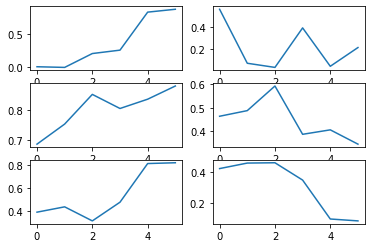

In [142]:
    f, axarr = plt.subplots(3,2) 

    axarr[0][0].plot(card_acc)
    axarr[0][1].plot(card_recall)
    axarr[1][0].plot(money_acc)
    axarr[1][1].plot(money_recall)
    axarr[2][0].plot(other_acc)
    axarr[2][1].plot(other_recall)